# Deloitte DEIA Case - Getting started  

This Jupyter notebook contains code snippets to get you started with the data.  Note that you are free to experiment with other training methods.  However, to compare your results easily with the current results, make sure that you apply the same evaluation method (i.e. apply max-pooling) as this notebook.  

Have fun!

##### Import relevant packages

In [1]:
import glob
import os

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, plot_precision_recall_curve
import matplotlib.pyplot as plt
from io import BytesIO
import requests
import statistics as st

### 1. Train model

#### 1.1 Load training data

In [2]:
# Load training database
path_training_db = "./data/training_data/training_array_kalimantan.npy"
train_arr = np.load(path_training_db)
print("Shape of train arr: %s" % str(train_arr.shape))

# We only take a small subset for this example
train_arr = train_arr[:, :100000]
print("Shape of subsetted train arr: %s" % str(train_arr.shape))

# For a column description, refer to attached Excel file
train_cols = ["AggIndex1", "AggIndex2", "AggIndex3", "AggIndex4", "AggIndex5", "CoastlineDistance",
        "CurrentMonth", "EdgeDensity1", "EdgeDensity2", "EdgeDensity3", "EdgeDensity4",
        "LandcoverPercentage1", "LandcoverPercentage2", "LandcoverPercentage3", 
        "LandcoverPercentage4", "LogRoadDistance", "PalmOilConcession", 
        "PalmOilMillsDistance", "PatchDensity1", "PatchDensity2", "PatchDensity3", 
        "PatchDensity4", "RawSarVisionClasses", "RoadsDistance", "SarvisionBasemap", 
        "ShannonDiversity", "UrbanicityDistance", "Vegetype", "WaterwaysDistance", 
        "current_deforestation_distance", "current_degradation_distance", "future_deforestation", 
        "gradientASTER", "scaledASTER", "scaledWorldPop"]

train_df = pd.DataFrame(train_arr.T, columns = train_cols)
print("Training dataframe shown below. Note that every row represent a 15x15m pixel.")
train_df.columns

Shape of train arr: (35, 5768728)
Shape of subsetted train arr: (35, 100000)
Training dataframe shown below. Note that every row represent a 15x15m pixel.


Index(['AggIndex1', 'AggIndex2', 'AggIndex3', 'AggIndex4', 'AggIndex5',
       'CoastlineDistance', 'CurrentMonth', 'EdgeDensity1', 'EdgeDensity2',
       'EdgeDensity3', 'EdgeDensity4', 'LandcoverPercentage1',
       'LandcoverPercentage2', 'LandcoverPercentage3', 'LandcoverPercentage4',
       'LogRoadDistance', 'PalmOilConcession', 'PalmOilMillsDistance',
       'PatchDensity1', 'PatchDensity2', 'PatchDensity3', 'PatchDensity4',
       'RawSarVisionClasses', 'RoadsDistance', 'SarvisionBasemap',
       'ShannonDiversity', 'UrbanicityDistance', 'Vegetype',
       'WaterwaysDistance', 'current_deforestation_distance',
       'current_degradation_distance', 'future_deforestation', 'gradientASTER',
       'scaledASTER', 'scaledWorldPop'],
      dtype='object')

#### 1.2. Preprocess data

In [3]:
# Drop NA rows (note this is not needed for all classifiers)
len_train_df = len(train_df)
train_df = train_df.dropna()
print("Dropped %s rows with NA" % (len_train_df - len(train_df)))

y_col = "future_deforestation"
X_cols = [col for col in train_cols if col != y_col]
X_train =  train_df[X_cols]
y_train = train_df[y_col]

# X_train = preprocessing.scale(X_train) # numerical issues
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)

Dropped 1047 rows with NA


#### 1.3. Train model

In [4]:
#model = LogisticRegression(max_iter=1000)
model = RandomForestClassifier()
model = model.fit(X_train, y_train)

### 2. Validate model

#### 2.1 Load validation data

In [5]:
# Load validation data
#path_validation_data ="./kalimantan/validation_hotzones/110.872E 0.111N 737254_hotzones.npy"
validation_data_files = glob.glob("./data/validation_hotzones/*.npy")
nr_tiles = 20

# Iterate over hotzone arrays and concatenate data
#    Note: we only take a few hotzones as an example
val_arrs = []
for i, path in enumerate(validation_data_files[:nr_tiles]):
    arr = np.load(path)
    # For simplicity sake we drop the hotzone array if one of the pixel values is NA (NOT RECOMMENDED)
    if sum(np.isnan(arr.reshape(-1))) > 0:
        print("WARNING: Dropping this tile because one of the pixel values is NA. Current i: %s" % i)
        continue
    else:
        val_arrs.append(arr)
    


val_arr = np.dstack(val_arrs)
val_cols = ["AggIndex1", "AggIndex2", "AggIndex3", "AggIndex4", "AggIndex5", "CoastlineDistance",
        "CurrentMonth", "EdgeDensity1", "EdgeDensity2", "EdgeDensity3", "EdgeDensity4",
        "LandcoverPercentage1", "LandcoverPercentage2", "LandcoverPercentage3", "LandcoverPercentage4",
        "LogRoadDistance", "PalmOilConcession", "PalmOilMillsDistance", "PatchDensity1", "PatchDensity2", 
        "PatchDensity3", "PatchDensity4", "RawSarVisionClasses", "RoadsDistance", "SarvisionBasemap",
        "ShannonDiversity", "UrbanicityDistance", "Vegetype", "WaterwaysDistance", 
        "current_deforestation_distance", "current_degradation_distance", "future_deforestation", 
        "gradientASTER", "scaledASTER", "scaledWorldPop", "RelativeXPoint", "RelativeYPoint"]
val_arr.shape

(37, 32, 5120)

###### Example hotzone array

A hotzone describes a 32x32 pixels area.  
One validation hotzone array consists of 20 hotzones underneath each other, describing the x and y value for every variable/column.  

See below for a graphical explanation. 

The diagram below shows a graphical representation of the 'future_deforestation' column. On the y-axis you can see 10 hotzones (next to each other, seperated by a black vertical line). Every 32x32 square describes one randomly sampled hotzone from the tile.

Feature (31): future_deforestation, shape: (32, 320)


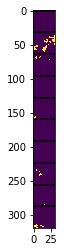

In [6]:
example_data ="./data/validation_hotzones/109.672E 0.911N 737254_hotzones.npy"
example_arr = np.load(example_data)

future_def_col_idx = val_cols.index('future_deforestation')
rel_arr = example_arr[31, :, :32*10]  # we select 10 hotzones 
lines = np.arange(0, rel_arr.shape[1] , 32) # used for graph
print("Feature (%s): %s, shape: %s" % (future_def_col_idx, val_cols[future_def_col_idx], rel_arr.shape))
plt.imshow(rel_arr.T, interpolation='nearest')
for coord in lines:
    plt.axhline(y=coord, color='black')
plt.show()

#### 2.3 Test model

In [7]:
X_idx = [i for i, col in enumerate(val_cols) if col != 'future_deforestation' and col in train_cols]
y_idx = val_cols.index('future_deforestation')
dim = val_arr.shape

val_arr_flat = val_arr.reshape((dim[0], dim[1] * dim[2])).T
X_test = val_arr_flat[:, X_idx]
X_test = scaler.transform(X_test) # used in training
y_actual = val_arr[y_idx, :, :]

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(dim[1], dim[2])

y_proba = model.predict_proba(X_test)[:, 1] # class 1 is relevant
y_proba = y_proba.reshape(dim[1], dim[2])

#### 2.4 Apply max-pooling  
Because performance is low at pixel-level, we aggregate predictions by max-pooling these. See example below

In [8]:
def max_pool_predictions(mat):
    """
    Applies the max-pooling step.
    This is done by reshaping into an intermediate 4D tensor,
    then taking the maxima along the new axes representing
    each grid.

    Args:
        mat: A float32 NumPy array of dimensions (height, width)

    Returns:
        A float32 NumPy array of dimensions (height/k_size, width/k_size)
    """
    k_size = 32 # 32 pixels = 480 meters
    m, n = mat.shape[:2]
    _ceil = lambda x, y: int(np.ceil(x / float(y)))
    ny = _ceil(m, k_size)
    nx = _ceil(n, k_size)
    size = (ny * k_size, nx * k_size)
    mat_pad = np.full(size, np.nan)
    mat_pad[:m, :n, ...] = mat
    if np.all(np.isnan(mat_pad)):
        return np.nan
    new_shape = (ny, k_size, nx, k_size)
    return np.nanmax(mat_pad.reshape(new_shape), axis=(1, 3))

# Returns an array with one prediction per hotzone (thus in this example 10 hotzones)
y_pred_max_pooled = max_pool_predictions(y_pred)
print("Shape of y_pred max pooled: %s" % str(y_pred_max_pooled.shape))

y_actual_max_pooled = max_pool_predictions(y_actual)
print("Shape of y_actual max pooled: %s" % str(y_actual_max_pooled.shape))

y_proba_max_pooled = max_pool_predictions(y_proba)

Shape of y_pred max pooled: (1, 160)
Shape of y_actual max pooled: (1, 160)


#### 2.5 Evaluate model

In [9]:
print("Number of predicted deforestation: %s" % sum(y_pred_max_pooled.T))
print("Number of actual deforestation : %s" % sum(y_actual_max_pooled.T))

conf_matrix = confusion_matrix(y_actual_max_pooled.T, y_pred_max_pooled.T)
conf_matrix

Number of predicted deforestation: [120.]
Number of actual deforestation : [38.]


array([[40, 82],
       [ 0, 38]], dtype=int64)

Text(0, 0.5, 'Precision')

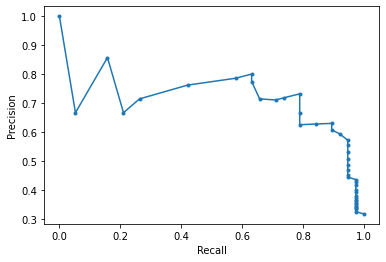

In [10]:
precision, recall, thresholds = precision_recall_curve(y_actual_max_pooled.T, y_proba_max_pooled.T)

plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Priorization of results

In this part of the code, priorization (demo) is applied to the actual predictions/results (y_proba_max_pooled).

#### Get feature values per hotzone and standardize

The feature values per hotzone have to be extracted in order to apply the prioritization. For this, the mean of all feature values for the pixels in a hotzone are taken.

In [11]:
def standardize_feature_value(index_feature, value):
    '''
    This will standardize the feature value which will make it possible to implement in the utility function
    z = (x - u) / s
    s = std of feature
    u = mean of feature
    x = feature value
    '''
    list_feature_index = [val_cols.index(i) for i in val_cols if i not in ['future_deforestation', 'RelativeXPoint', 'RelativeYPoint']]
    s = np.std(val_arr[index_feature, :, :])
    if float(s) == float(0):
        s = s + 1
    u = np.mean(val_arr[index_feature, :, :])
    standardized_value = (value-u) / s
    return standardized_value

def get_feature_values_prediction(hotzone_nr):
    '''
    This function will return all feature values (the mean) for the hotzone_nr you give as an input. 
    Moreover, this function will also standardize these feature values using the standardscaler in order to apply them in the utility function.
    '''
    list_feature_index = [val_cols.index(i) for i in val_cols if i not in ['future_deforestation', 'RelativeXPoint', 'RelativeYPoint']]
    hotzone_nr = hotzone_nr - 1
    hot_zone_index = 32 * (hotzone_nr)
    extra_index = hot_zone_index + 32
    #print(hot_zone_index)
    #print(extra_index)
    all_features = [np.mean(val_arr[i, :32, hot_zone_index:extra_index]) for i in list_feature_index]
    return [standardize_feature_value(i,j) for i,j in zip(list_feature_index, all_features)]

#### Read data google forms

The data used in this demo is collected via a google form. This code will read the form and write the data to a dataframe.

In [13]:
train_df.columns

Index(['AggIndex1', 'AggIndex2', 'AggIndex3', 'AggIndex4', 'AggIndex5',
       'CoastlineDistance', 'CurrentMonth', 'EdgeDensity1', 'EdgeDensity2',
       'EdgeDensity3', 'EdgeDensity4', 'LandcoverPercentage1',
       'LandcoverPercentage2', 'LandcoverPercentage3', 'LandcoverPercentage4',
       'LogRoadDistance', 'PalmOilConcession', 'PalmOilMillsDistance',
       'PatchDensity1', 'PatchDensity2', 'PatchDensity3', 'PatchDensity4',
       'RawSarVisionClasses', 'RoadsDistance', 'SarvisionBasemap',
       'ShannonDiversity', 'UrbanicityDistance', 'Vegetype',
       'WaterwaysDistance', 'current_deforestation_distance',
       'current_degradation_distance', 'future_deforestation', 'gradientASTER',
       'scaledASTER', 'scaledWorldPop'],
      dtype='object')

In [15]:
def read_survey():
    r = requests.get('https://docs.google.com/spreadsheet/ccc?key=10jMcZFp8D58apJRkqt2sblmm64Vq7CF1_HNxzscQrl0&output=csv')
    data = r.content
    df = pd.read_csv(BytesIO(data))
    df.columns = ['timestamp', 'critical_species', 'timber', 'national_parks', 'palmoil', 'save_travel', 'citizens', 'availability_water', 'availability_roads', 'natural_water', 'permit_areas', 'important', '2important', '3important', '4important']
    df = df[df.columns[1:]]
    return df

def last_answer():
    df = read_survey()
    df = df.iloc[-1:]
    return df


importance_categories = {
    'critical_species': ['critical_species'],
    'area_demographics': ['national_parks', 'availability_water', 'availability_roads', 'natural_water'],
    'availibility_resources': ['timber', 'palmoil'],
    'urbanicity': ['save_travel', 'citizens']
}

features_links = {
    'critical_species': [], #We currently do not have all data and so also not this column
    'timber': [], #We currently do not have all data and so also not this column
    'national_parks': [], #We currently do not have all data and so also not this column
    'palmoil': ['PalmOilMillsDistance', 'PalmOilMillsDistance'],
    'save_travel': ['UrbanicityDistance'],
    'citizens': ['UrbanicityDistance'],
    'availability_water': ['WaterwaysDistance'],
    'availability_roads': ['LogRoadDistance'],
    'natural_water': [], #We currently do not have all data and so also not this column
    'permit_areas': [] #We currently do not have all data and so also not this column
}

read_survey()

,critical_species,timber,national_parks,palmoil,save_travel,citizens,availability_water,availability_roads,natural_water,permit_areas,important,2important,3important,4important
0,2,1,3,4,5,4,5,2,5,5,Critical Species,Area Demographics,Availability of resources,Urbanicity
1,1,4,4,2,4,5,5,5,5,5,Area Demographics,Urbanicity,Availability of resources,Critical Species
2,3,4,1,4,2,4,3,5,5,5,Urbanicity,Critical Species,Availability of resources,Area Demographics


#### Prioritize the data from the form

The priorization value for each hotzone is needed in order to give an output of which of the predictions is the most important to the user. 

In [41]:
def priorization_value(hotzone_nr):
    '''
    This function will determine the value for the prioritization using the utility values and the feature values.
    '''
    
    column_index = [val_cols.index(i) for i in val_cols if i not in ['future_deforestation', 'RelativeXPoint', 'RelativeYPoint']]
    column_names = [val_cols[i] for i in column_index]
    df_results = last_answer() #Deze moeten dus nog worden gescaled
    prediction = y_proba_max_pooled[:, hotzone_nr-1] #The predicted value is retreived
    
    
    #Apply the utility function
    answer = sum([df_results[j].values * st.mean([get_feature_values_prediction(50)[column_names.index(i)] for i in features_links[j]]) * prediction 
                  for j in features_links.keys() if len(features_links[j]) > 0])

    return answer

#### Output the top-k number of prioritized values

In this part, the output the top-k number of prioritized values together with their likelyhood deforestation is going to happen is printed to the user.

In [58]:
def give_priorization(nr_outputs):
    '''
    This function prioritizes all the data and the associated probabilities.
    '''
    all_values = [(idx , priorization_value(i)) for idx,i in enumerate(range(1,y_proba_max_pooled.shape[1] + 1))]
    sorted_priorizations = sorted(all_values, key=lambda data: data[1], reverse=True)
    sorteds = sorted_priorizations[0:nr_outputs]
    data = [[i[0] + 1, i[1][0], y_proba_max_pooled[:,i[0]][0]] for i in sorteds]
    headers = ['Hotzone Number', 'Prioritization Value', 'Deforestation Prediction']
    print(pd.DataFrame(data, columns=headers, index=np.arange(1, len(data) + 1)))


In [59]:
give_priorization(10)

    Hotzone Number  Prioritization Value  Deforestation Prediction
1                1                   0.0                       0.0
2                2                   0.0                       0.0
3                3                   0.0                       0.0
4                4                   0.0                       0.0
5                8                   0.0                       0.0
6              141                   0.0                       0.0
7              142                   0.0                       0.0
8              143                   0.0                       0.0
9              144                   0.0                       0.0
10             145                   0.0                       0.0
